# Vertex Cover Problem
### Description
The Vertex Cover Problem (VCP) is a well-known problem with a lot of utility in the real world.
The problem implies covering as much edges as possible using as little vertices as possible.

### Utility in the real world
The solution of Vertex Cover Problem can be used to solve important real-life problems, using basically the same "blue-print". Some of them are:
- Optimizing communication networks. We can assume that a point of controll of the network is a vertex, and then the goal is to monitor the whole network (***maximizing edges***) with as little resources as possible (***minimizing vertices***).
- Urban planification and infrastructure development. We can imagine that edges are the roads, and we need to find where to build different important buildings (vertices)
- Traffic surveilence. Same as before, we can imagine that edges are the roads, but now at the intersection of those roads (vertices) we want to install cameras and sensors to survey the traffic.

# Initialize the problem
We will import the necessary libraries and create a graph at random that will be used to compare the ***Genetic Evolution Algorithm*** and the ***Discrete Particle Swarm Optimization***.

To run the program the following libraries are required:
- Networkx
- Numpy
- Matplotlib
- PrettyTable
- Scipy (required for generating a graph with many vertices)

In [41]:
# Import required libraries
import networkx as nx
import matplotlib.pyplot as plt
from algorithms.genetic_algorithm import GeneticAlgorithm
from utils.generate_graph import GenerateGraph

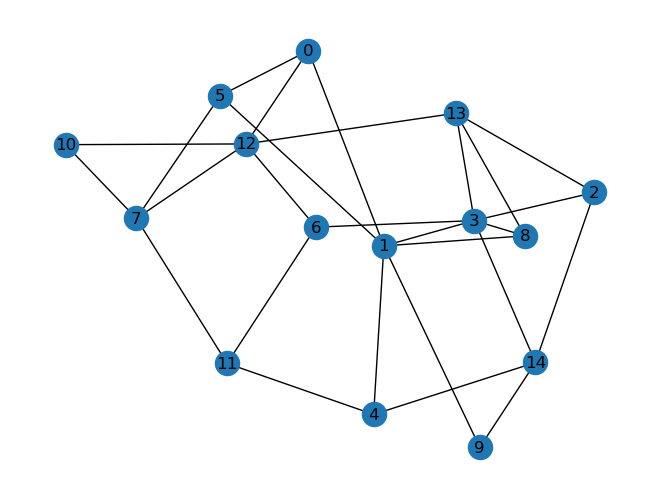

In [42]:
generated_graph = GenerateGraph(15, 0.25) # number of vertices, change of edge between two vertices

pos = nx.spring_layout(generated_graph.get_graph())
nx.draw(generated_graph.get_graph(), pos, with_labels=True)
plt.show()

# Genetic Evolution Algorithm
When using the Genetic Evolution Algorithm (GA for short) we will store our result for the problem as a binary sequence that is equal to the number of vertices, but why?
Well, we do this because in this way we can easily represent what vertices are used, for example if we have a graph with 5 vertices then a possible solution for the VCP will look something like this: [0, 1, 1, 0, 1];
Ok, that's the easy, but where the evolution does take place? Let's forget that [0, 1, 1, 0, 1] it's a binary sequence, let's imagine it's DNA. From the evolution theory it's known that if two creatures mate they will produce a new creature that will share parts of their DNA, or even mutate and gain "new features". Of course in real-life it's more than that, and the process of evolution expands over bilion of years. Ok, now let's get back to our binary sequences, if we imagine them as DNA we can initialize our own "species of creatures" and breed them. 
Breeding them will result in obtaining a solution for our problem, but how?
We will calculate using a ***fitness function*** how good they are at the "life they live", what do I mean by that? I'm just saying that we are going to calculate how good is their DNA, their DNA being the soultion for our problem. And one more thing, we will add an "elitism" factor, what does this mean? It means we will keep a predefined number of our best candidates to the future generation (basically the elites).

These are the steps for the GA:
1. Initialize a population of a desired size.
2. Create a loop for a desired number of generations.
3. Calculate the fitness of each individual, store the best in a list.
4. Breed them, check if the children will mutate (a random chance) and change them accordingly.
5. Go to the next generation
6. When the loop is complete, from the list with the best individuals in each generation, select the best of all time.
7. Enjoy your result to the problem.

In [43]:
genetic_algorithm = GeneticAlgorithm(generated_graph, 50, 1000, 0.5, 5, 2)
genetic_algorithm.run()

Current generation 0/1000
Current generation 10/1000
Current generation 20/1000
Current generation 30/1000
Current generation 40/1000
Current generation 50/1000
Current generation 60/1000
Current generation 70/1000
Current generation 80/1000
Current generation 90/1000
Current generation 100/1000
Current generation 110/1000
Current generation 120/1000
Current generation 130/1000
Current generation 140/1000
Current generation 150/1000
Current generation 160/1000
Current generation 170/1000
Current generation 180/1000
Current generation 190/1000
Current generation 200/1000
Current generation 210/1000
Current generation 220/1000
Current generation 230/1000
Current generation 240/1000
Current generation 250/1000
Current generation 260/1000
Current generation 270/1000
Current generation 280/1000
Current generation 290/1000
Current generation 300/1000
Current generation 310/1000
Current generation 320/1000
Current generation 330/1000
Current generation 340/1000
Current generation 350/1000
Cur

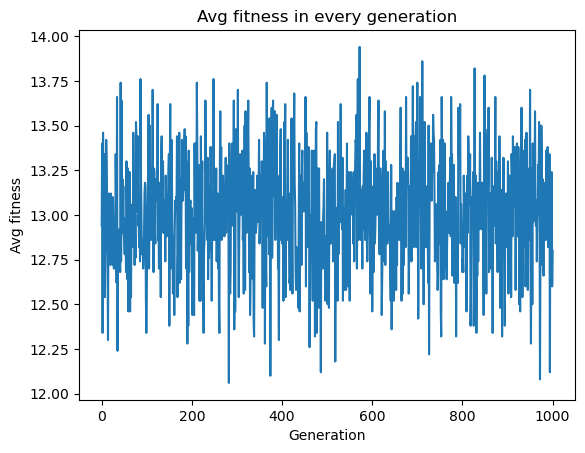

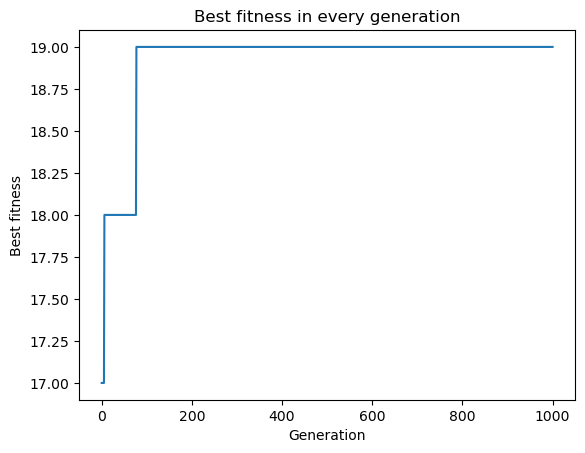

+------------+---------------------------------+
| Generation |            Individual           |
+------------+---------------------------------+
|     0      | [1 1 0 1 1 0 0 1 0 0 1 1 0 1 1] |
|     1      | [1 1 0 1 1 0 0 1 0 0 1 1 0 1 1] |
|     2      | [1 1 0 1 1 0 0 1 0 0 1 1 0 1 1] |
|     3      | [1 1 0 1 1 0 0 1 0 0 1 1 0 1 1] |
|     4      | [1 1 0 1 1 0 0 1 0 0 1 1 0 1 1] |
|     5      | [1 1 0 1 1 0 0 1 0 0 1 1 0 1 1] |
|     6      | [1 1 0 1 0 0 0 0 0 0 1 1 1 1 1] |
|     7      | [1 1 0 1 0 0 0 0 0 0 1 1 1 1 1] |
|     8      | [1 1 0 1 0 0 0 0 0 0 1 1 1 1 1] |
|     9      | [1 1 0 1 0 0 0 0 0 0 1 1 1 1 1] |
|     10     | [1 1 0 1 0 0 0 0 0 0 1 1 1 1 1] |
|     11     | [1 1 0 1 0 0 0 0 0 0 1 1 1 1 1] |
|     12     | [1 1 0 1 0 0 0 0 0 0 1 1 1 1 1] |
|     13     | [1 1 0 1 0 0 0 0 0 0 1 1 1 1 1] |
|     14     | [1 1 0 1 0 0 0 0 0 0 1 1 1 1 1] |
|     15     | [1 1 0 1 0 0 0 0 0 0 1 1 1 1 1] |
|     16     | [1 1 0 1 0 0 0 0 0 0 1 1 1 1 1] |
|     17     | [1 1 

In [44]:
# We show the metrics
genetic_algorithm.show_metrics()

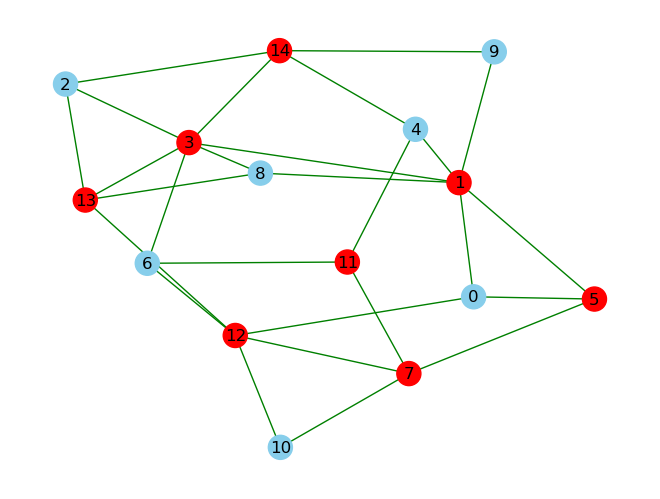

The best individual is [0 1 0 1 0 1 0 1 0 0 0 1 1 1 1] with a fitness of 19


In [46]:
# We show the solution
genetic_algorithm.show_solution()

# Discrete Particle Swarm Optimization Algorithm